In [1]:
import ants
import numpy as np

# Loading the Synthetic data (Reference Block)

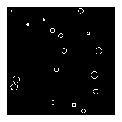

In [2]:
reference_image = ants.image_read('./synthetic_data/0_percent_fixed.nii.gz')
#moving_image = ants.image_read('0_percent_moving.nii.gz')
ants.plot(reference_image, axis=0, nslices=1)
#ants.plot(moving_image, axis=0, nslices=1)

# Showing the ANTsImage object.
The sample image is a 763x255x255 image. It is a grayscale image and hence has 1 component. It is in the RAI orientation.

In [3]:
print(reference_image)

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (763, 255, 255)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]



# Getting a cropped image from the original image
The size of the cropped image is defined by patch_size. If patch_size is P, then the cropped image is of size PxPxP.

In [4]:
def get_patch(reference_image, x1, y1, z1, patch_size_x, patch_size_y, patch_size_z):
    #x = reference_image.shape[0]//2
    #y = reference_image.shape[1]//2
    #k = patch_size
    patch = ants.crop_indices(reference_image,(x1,y1, z1), (x1+patch_size_x,y1+patch_size_y, z1+patch_size_z))
    return patch

# ANTs Registration

In [5]:
def register_image(fixed, moving):
    reg = ants.registration(fixed, moving, type_of_transform="SyNRA", verbose=False) # SyNRA
    return reg

# Measuring the global warping
Calculating the sum of absolute value of each pixel in the log jacobian determinant image of the moving image after registration.

In [6]:
def calculate_global_warping(fixed, transform_file):
    jac = ants.create_jacobian_determinant_image(fixed,transform_file,1,0)
    return np.sum(np.abs(jac.numpy()))

# Sliding Registration
Sliding the cropped image through a smaller region in the original image and registering at every position of (x,y,z).

In this case, our cropped image(tissue block) is taken from the position (356, 102, 102) in the image. We slide this cropped image from (352,99,99) to (359,105,105) and register at every position of (x,y,z). We calculate the global warping for each registration. Theoretically,after the sliding registration is complete, our best match should be at position (356,102,102)

In [7]:
def sliding_registration(reference_image, moving_image):
    #print("Sliding Registration Started")
    ref_dims = (reference_image.shape[0], reference_image.shape[1], reference_image.shape[2])
    mov_dims = (moving_image.shape[0], moving_image.shape[1], moving_image.shape[2])
    jac_all = []
    reg_dict = {}
    #patch_size = 8
    num = 1
    #tot_regs = (ref_dims[0]-mov_dims[0])*(ref_dims[1]-mov_dims[1])*(ref_dims[2]-mov_dims[2])
    #print("Total Registrations to process:", tot_regs)
    for i in range(352,359): # 0,ref_dims[0]-mov_dims[0]+1
        for j in range(99,105): # 0,ref_dims[1]-mov_dims[1]+1
            for k in range(99,105): # 0,ref_dims[2]-mov_dims[2]+1
                print("Registration Number:" + str(num))
                num += 1
                fixed = get_patch(reference_image, i, j, k, mov_dims[0], mov_dims[1], mov_dims[2])
                #print(fixed)
                #print(moving_image)
                #moving = get_patch(reference_image, i, j, patch_size)
                reg = register_image(fixed, moving_image)
                #print(reg)
                if len(reg['fwdtransforms']) != 0:
                    print("NON-ZERO TRANSFORM")
                    jac = calculate_global_warping(fixed, reg['fwdtransforms'][0])
                    jac_all.append((jac, i, j, k))
                    reg_dict[(i,j, k)] = (reg,fixed)
                else:
                    print("ZERO TRANSFORM")
                print("++++++++++++-------------------+++++++++++")
    return jac_all, reg_dict

# Taking a central cropped image and running the sliding registration
We take a cropped image of size 50x50x50 from the center of the original image. The (x,y,z) coordinate of the origin of cropped image is (356, 102, 102). 

In [8]:
# Get central patch (tissue block)
patch_size = 50
x1_ref = (reference_image.shape[0]//2) - (patch_size//2)
y1_ref = (reference_image.shape[1]//2) - (patch_size//2)
z1_ref = (reference_image.shape[2]//2) - (patch_size//2)
moving_image = get_patch(reference_image, x1_ref, y1_ref, z1_ref, patch_size, patch_size, patch_size)
print(f"Position of cropped image(tissue block): ({x1_ref}, {y1_ref}, {z1_ref})")


Position of cropped image(tissue block): (356, 102, 102)


In [9]:
jac_all, reg_dict = sliding_registration(reference_image,moving_image)

Registration Number:1
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:2
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:3
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:4
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:5
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:6
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:7
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:8
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:9
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:10
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:11
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:12
NON-ZERO TRANSFORM
++++++++++++-------------------+

NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:99
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:100
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:101
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:102
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:103
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:104
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:105
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:106
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:107
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:108
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:109
NON-ZERO TRANSFORM
++++++++++++-------------------+++++

NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:195
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:196
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:197
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:198
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:199
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:200
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:201
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:202
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:203
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:204
NON-ZERO TRANSFORM
++++++++++++-------------------+++++++++++
Registration Number:205
NON-ZERO TRANSFORM
++++++++++++-------------------++++

# Total number of registrations done during sliding registration
We do a total of 252 registrations

In [10]:
print(len(jac_all))

252


# Get the best Match position
We get the best match's position. The best match should have the lowest value of the global warping. In our case, it should be at position (356, 102, 102) since that is the position from where the original cropped image was taken.

The first value in the given output list of all glaobal warping values will the best match. It is defined as (global warping value, x-coordinate of origin, y-coordinate of origin, z-coordinate of origin)

In [11]:
jac_all.sort(key=lambda x:x[0])
jac_all

[(1098.7556, 356, 102, 102),
 (1491.9414, 353, 103, 102),
 (1632.2842, 357, 102, 102),
 (1647.0857, 352, 104, 102),
 (1656.3427, 356, 99, 102),
 (1661.592, 352, 99, 102),
 (1677.2065, 357, 99, 102),
 (1681.2489, 358, 102, 102),
 (1688.4779, 356, 103, 102),
 (1697.4362, 356, 101, 102),
 (1697.5448, 355, 102, 102),
 (1708.4491, 355, 99, 102),
 (1713.678, 356, 103, 101),
 (1720.2604, 355, 104, 102),
 (1726.0317, 356, 101, 104),
 (1731.9093, 356, 102, 104),
 (1753.8109, 354, 99, 102),
 (1758.9424, 357, 101, 102),
 (1778.6324, 356, 103, 103),
 (1779.2625, 357, 99, 103),
 (1781.8539, 353, 102, 102),
 (1812.1459, 352, 101, 104),
 (1814.0194, 352, 101, 103),
 (1820.5791, 356, 104, 102),
 (1822.4359, 356, 102, 103),
 (1828.1405, 355, 102, 103),
 (1834.2904, 356, 99, 103),
 (1850.1536, 353, 101, 102),
 (1851.7601, 357, 104, 102),
 (1851.9009, 355, 102, 101),
 (1861.3551, 357, 103, 102),
 (1884.487, 355, 101, 102),
 (1887.4503, 352, 102, 104),
 (1889.2657, 358, 104, 102),
 (1901.589, 356, 102, 10

In [12]:
# USE ONLY IF USING NON-LOG JACOBIAN DETERMINANT IMAGE FOR MEASURING GLOBAL WARPING.

#jac_all_c = []
#for i,j,k, l in jac_all:
#    val = (abs(i-(i - patch_size**2)), j, k, l)
#    jac_all_c.append(val)

In [13]:
#jac_all_c.sort(key=lambda x:x[0])
#jac_all_c

In [14]:
len(reg_dict)

252

# Details of registered image and corresponding fixed image
Change the value of (x1_ref, y1_ref, z1_ref) to get details of registered image and fixed image at that index/position.

In [15]:
ref_match = reg_dict[(x1_ref,y1_ref, z1_ref)]
ref_match

({'warpedmovout': ANTsImage (RAI)
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (50, 50, 50)
  	 Spacing    : (1.0, 1.0, 1.0)
  	 Origin     : (356.0, 102.0, 102.0)
  	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
  'warpedfixout': ANTsImage (RAI)
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (50, 50, 50)
  	 Spacing    : (1.0, 1.0, 1.0)
  	 Origin     : (356.0, 102.0, 102.0)
  	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
  'fwdtransforms': ['/var/folders/1g/0yylg_z95lx5zcn3dpkgb9tr0000gn/T/tmph485aw0b1Warp.nii.gz',
   '/var/folders/1g/0yylg_z95lx5zcn3dpkgb9tr0000gn/T/tmph485aw0b0GenericAffine.mat'],
  'invtransforms': ['/var/folders/1g/0yylg_z95lx5zcn3dpkgb9tr0000gn/T/tmph485aw0b0GenericAffine.mat',
   '/var/folders/1g/0yylg_z95lx5zcn3dpkgb9tr0000gn/T/tmph485aw0b1InverseWarp.nii.gz']},
 ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (50, 50, 50)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (356.0, 102.0,

# Some Helpful visualizations
1. Moving image after registration
2. Moving image before registration
3. Fixed image at that position

In this case, all three look the same because we are visualizing the cropped image and the best match registration.

In [16]:
ref_fixed = ref_match[1]
ref_reg = ref_match[0]

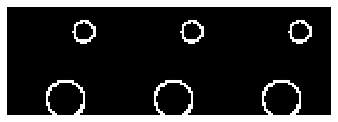

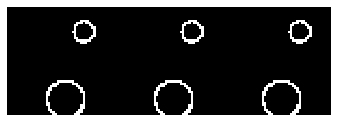

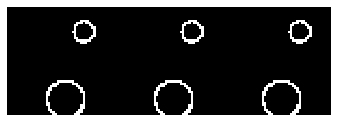

In [17]:
ants.plot(ref_reg['warpedmovout'], slices=(0,0,0))
ants.plot(moving_image, slices=(0,0,0))
ants.plot(ref_fixed, slices=(0,0,0))

Visualizing:
1. Warped image overlayed on moving image
2. Moving image overlayed on Fixed image
3. Warped image overlayed on Fixed image

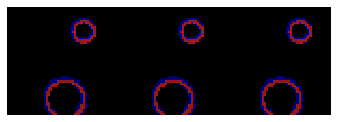

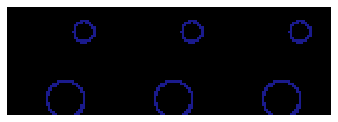

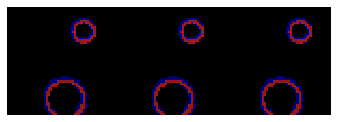

In [18]:
ants.plot(moving_image, ref_reg['warpedmovout'], slices=(0,0,0))
ants.plot(ref_fixed, moving_image, slices=(0,0,0))
ants.plot(ref_fixed, ref_reg['warpedmovout'], slices=(0,0,0))

Visualizing the grid deformation/warping of moving image after it is registered to the fixed image.


In [19]:
mywarpedgrid = ants.create_warped_grid( moving_image, grid_directions=(True,True, True),
                        transform=ref_reg['fwdtransforms'], fixed_reference_image=ref_fixed )

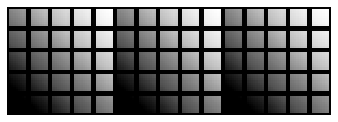

In [20]:
ants.plot(mywarpedgrid, slices=(0,0,0))

Visualizing the Log Jacobian Determinant(LJD) Image and looking at the value of the Log Jacobian Determinant for each pixel.

If LJD = 0 -> No change

If LJD = -ve -> Contraction

If LJD = +ve -> Expansion

In [21]:
jac_viz = ants.create_jacobian_determinant_image(ref_fixed,ref_reg['fwdtransforms'][0],1,0)

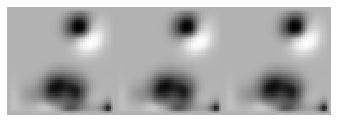

In [22]:
ants.plot(jac_viz, slices=(0,0,0))

In [23]:
jac_viz[:][:][:]

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -4.43852732e-11, -1.33155709e-10, ...,
         -1.19191111e-06, -3.97311823e-07,  0.00000000e+00],
        [ 0.00000000e+00, -1.33155709e-10, -3.99462352e-10, ...,
         -3.57587487e-06, -1.19190349e-06,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  4.12555710e-06,  1.23444452e-05, ...,
          1.41728851e-11,  4.70845585e-12,  0.00000000e+00],
        [ 0.00000000e+00,  1.36435040e-06,  4.07561765e-06, ...,
          4.70845585e-12,  1.55853108e-12,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00, -1.25532917e-12, -3.76820797e-12, ...,
         -1.26030800e-05, -4.20084916e-06,  0.00000000e+00],
        [-9.89430760e-12, -1.55394397e-09, -4.56942706e-09, ...,
         -4.99129746e-05, -1.72914388e